<a href="https://colab.research.google.com/github/derek-byte/Melanoma_Deep_Learning/blob/main/Melamona-Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [64]:
train_dir='/content/drive/MyDrive/Melanoma_Dataset/train'
Labels = ['Melanoma', 'Non-Melanoma']
print ("class : ") 
for i in range(len(Labels)): 
    print (i, end = " ") 
    print (Labels[i])

class : 
0 Melanoma
1 Non-Melanoma


In [51]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16 

In [52]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.3)
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)
validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 7290 images belonging to 2 classes.
Found 3123 images belonging to 2 classes.


In [59]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE])
do_fine_tuning = False 
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 flatten_3 (Flatten)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               655872    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 2,914,882
Trainable params: 656,898
Non-trainable params: 2,257,984
_________________

In [60]:
LEARNING_RATE = 0.001 
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [61]:
EPOCHS=15
history = model.fit(
        train_generator,
        # steps_per_epoch = train_generator.samples//train_generator.batch_size,
        steps_per_epoch = 10,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/15
10/10 [==============================] - 94s 10s/step - loss: 0.8857 - accuracy: 0.6938 - val_loss: 0.1639 - val_accuracy: 0.9372
Epoch 2/15
10/10 [==============================] - 90s 10s/step - loss: 0.7252 - accuracy: 0.8250 - val_loss: 0.3108 - val_accuracy: 0.8917
Epoch 3/15
10/10 [==============================] - 90s 10s/step - loss: 0.2225 - accuracy: 0.9187 - val_loss: 0.1085 - val_accuracy: 0.9596
Epoch 4/15
10/10 [==============================] - 90s 10s/step - loss: 0.2632 - accuracy: 0.9125 - val_loss: 0.1244 - val_accuracy: 0.9532
Epoch 5/15
10/10 [==============================] - 90s 10s/step - loss: 0.1568 - accuracy: 0.9500 - val_loss: 0.1015 - val_accuracy: 0.9631
Epoch 6/15
10/10 [==============================] - 90s 10s/step - loss: 0.3290 - accuracy: 0.9000 - val_loss: 0.1986 - val_accuracy: 0.9131
Epoch 7/15
10/10 [==============================] - 89s 10s/step - loss: 0.1786 - accuracy: 0.9375 - val_loss: 0.0858 - val_accuracy: 0.9705
Epoch 8/15
10

Checking Performance

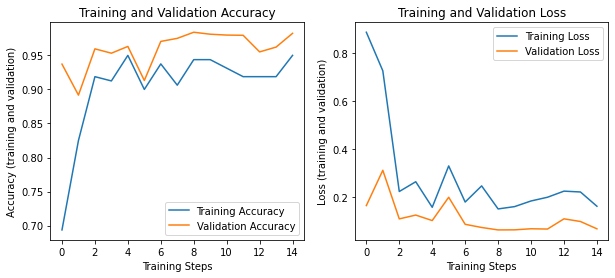

In [62]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

Test At Random

NotMelanoma/ISIC_0024402.jpg
class: Non-Melanoma, confidence: 0.983259


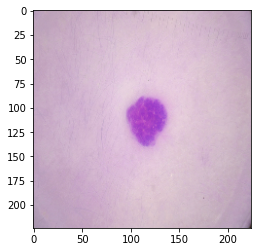

<Figure size 432x288 with 0 Axes>

Melanoma/AUG_0_2186.jpeg
class: Melanoma, confidence: 0.732708


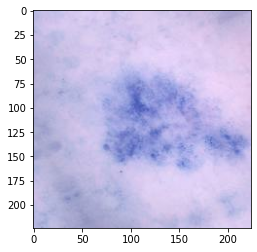

NotMelanoma/ISIC_0026091.jpg
class: Non-Melanoma, confidence: 0.976634


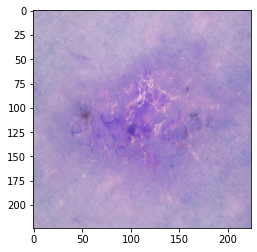

<Figure size 432x288 with 0 Axes>

Melanoma/AUG_0_1266.jpeg
class: Melanoma, confidence: 0.972900


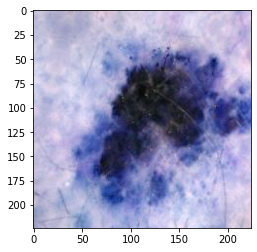

<Figure size 432x288 with 0 Axes>

NotMelanoma/ISIC_0024643.jpg
class: Non-Melanoma, confidence: 0.982885


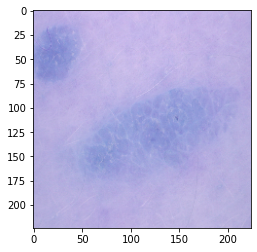

<Figure size 432x288 with 0 Axes>

NotMelanoma/ISIC_0026467.jpg
class: Non-Melanoma, confidence: 0.999421


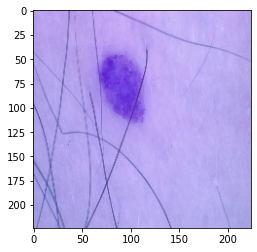

<Figure size 432x288 with 0 Axes>

Melanoma/AUG_0_2923.jpeg
class: Melanoma, confidence: 0.987587


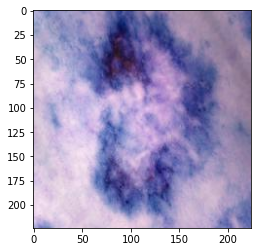

<Figure size 432x288 with 0 Axes>

NotMelanoma/ISIC_0025942.jpg
class: Non-Melanoma, confidence: 0.876668


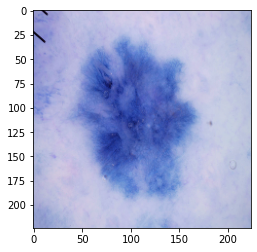

<Figure size 432x288 with 0 Axes>

Melanoma/AUG_0_2284.jpeg
class: Melanoma, confidence: 0.919581


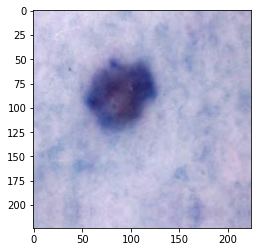

<Figure size 432x288 with 0 Axes>

NotMelanoma/ISIC_0027129.jpg
class: Non-Melanoma, confidence: 0.989059


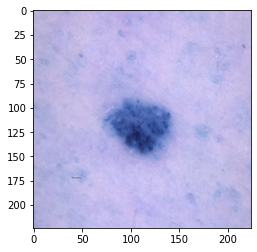

<Figure size 432x288 with 0 Axes>

Melanoma/AUG_0_1830.jpeg
class: Melanoma, confidence: 0.972402


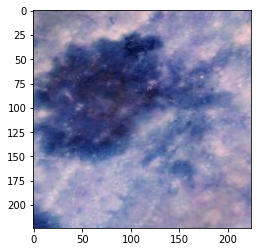

<Figure size 432x288 with 0 Axes>

Melanoma/AUG_0_1361.jpeg
class: Melanoma, confidence: 0.869016


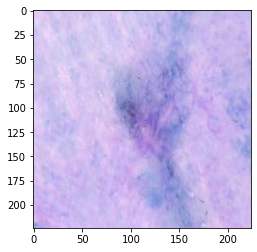

<Figure size 432x288 with 0 Axes>

Melanoma/AUG_0_1161.jpeg
class: Melanoma, confidence: 0.948326


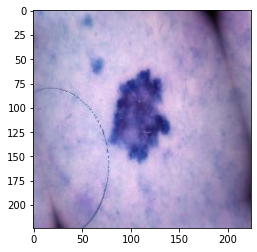

<Figure size 432x288 with 0 Axes>

Melanoma/AUG_0_4308.jpeg
class: Melanoma, confidence: 0.998661


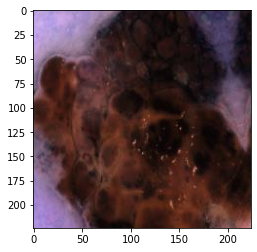

<Figure size 432x288 with 0 Axes>

Melanoma/AUG_0_4251.jpeg
class: Melanoma, confidence: 0.984950


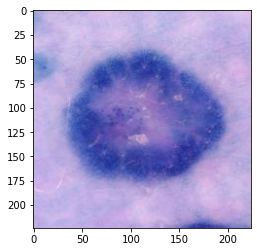

<Figure size 432x288 with 0 Axes>

NotMelanoma/ISIC_0025393.jpg
class: Non-Melanoma, confidence: 0.999449


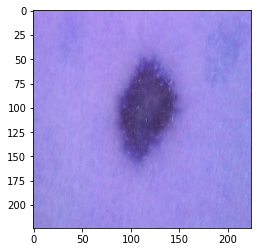

<Figure size 432x288 with 0 Axes>

In [74]:
import random
import cv2
def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255
    return img
def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)
    return {Labels[classx]: x[classx]}
images = random.sample(validation_generator.filenames, 16)
for idx, filename in enumerate(images):
    img = upload(filename)
    prediction = pre_result(img)
    print(filename)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

Confusion Matrix

In [66]:
from sklearn.metrics import classification_report, confusion_matrix

predictions1 = model.predict(validation_generator, steps=len(validation_generator))
y = np.argmax(predictions1, axis=1)

print('Classification Report')
cr = classification_report(y_true=validation_generator.classes, y_pred=y, target_names=validation_generator.class_indices)
print(cr)

evaluates = model.evaluate(validation_generator)
print(evaluates)

Classification Report
              precision    recall  f1-score   support

    Melanoma       0.97      0.99      0.98      1521
 NotMelanoma       0.99      0.97      0.98      1602

    accuracy                           0.98      3123
   macro avg       0.98      0.98      0.98      3123
weighted avg       0.98      0.98      0.98      3123

196/196 [==============================] - 85s 433ms/step - loss: 0.0641 - accuracy: 0.9859
[0.06407857686281204, 0.9859110116958618]


Confusion Matrix


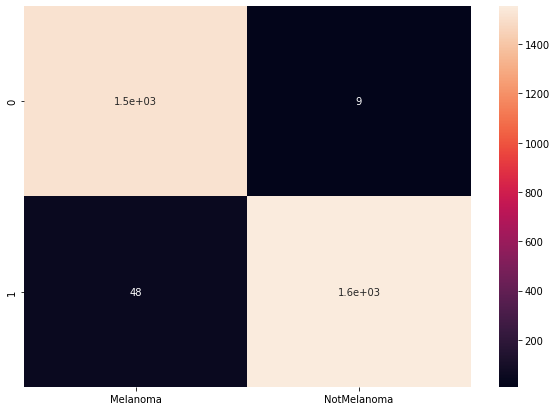

In [67]:
import pandas as pd
import numpy as np
import seaborn as sn
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y)
df = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df, annot=True)

Export as Saved Model and Convert to TFLite

In [70]:
import time
t = time.time()
export_path = "/content/drive/MyDrive/Melanoma_Models{}".format(int(t))
tf.keras.models.save_model(model, export_path)
export_path

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Melanoma_Models_Good_Copy/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Melanoma_Models_Good_Copy/assets


'/content/drive/MyDrive/Melanoma_Models_Good_Copy'

In [71]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    return {Labels[class_idx]: probabilities[class_idx]}

SOURCE: class: NotMelanoma, file: NotMelanoma/ISIC_0025934.jpg
PREDICTED: class: Non-Melanoma, confidence: 0.998537


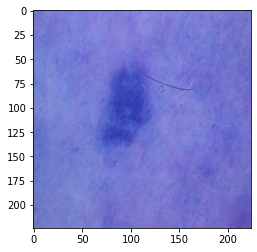

<Figure size 432x288 with 0 Axes>

SOURCE: class: NotMelanoma, file: NotMelanoma/ISIC_0026513.jpg
PREDICTED: class: Non-Melanoma, confidence: 0.820528


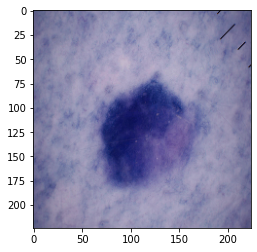

In [72]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    img = upload(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [73]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/model.tflite"
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))
# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)
# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

mkdir: cannot create directory ‘tflite_models’: File exists


11555024